In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [2]:
# Set your desired image size
BATCH_SIZE = 32
IMAGE_SIZE = (256,256)
CHANNELS=3
EPOCHS=50

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'pl_data',
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 6652 files belonging to 3 classes.


In [13]:
class_names = dataset.class_names
class_names

['Early_blight', 'Late_blight', 'healthy']

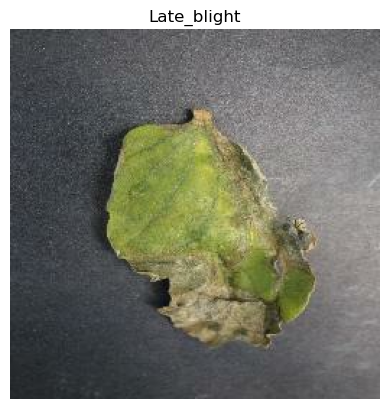

In [14]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[0]])
    plt.axis('off')

In [15]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 1 1 2 2 0 1 1 1 0 2 2 1 1 0 1 1 2 1 2 1 1 2 2 1 0 1 1 2 0 1]


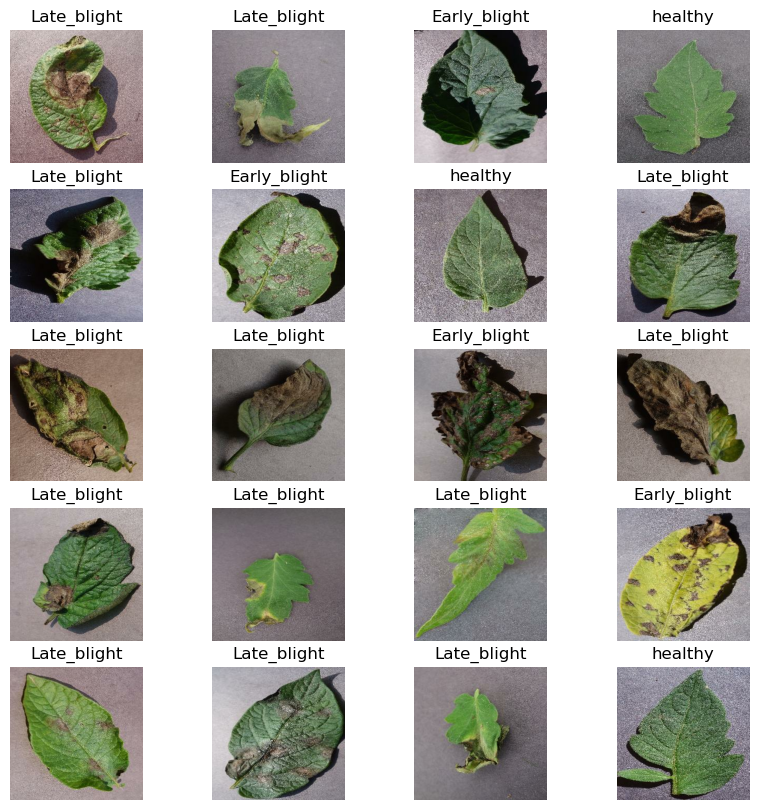

In [16]:
## Visualize some of the images from our dataset

plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [17]:
len(dataset)

208

In [18]:
train_size = 0.8
len(dataset)*train_size

166.4

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

154

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

166
20
22


In [23]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [24]:
# Building the Model

# Using Functional API for more flexibility
input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))
resized_and_rescaled = layers.experimental.preprocessing.Rescaling(1./255)(input_layer)

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [25]:
# Apply data augmentation to the input data
augmented_data = data_augmentation(resized_and_rescaled, training=True)

In [26]:
# Build the rest of the model architecture
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(augmented_data)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

In [27]:
# Output layer with softmax activation
output_layer = layers.Dense(10, activation='softmax')(x)

In [28]:
# Create the model using the functional API
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [29]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Display Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                             

In [30]:

# Training the Model

# Increase the number of epochs for better training
#epochs = 3

# Use model.fit instead of model.fit_generator, as it is more common in recent TensorFlow versions
my_model = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)


Epoch 1/50
166/166 [==============================] - 139s 795ms/step - loss: 1.3100 - accuracy: 0.3634 - val_loss: 1.0797 - val_accuracy: 0.4062
Epoch 2/50
166/166 [==============================] - 130s 786ms/step - loss: 0.9616 - accuracy: 0.5164 - val_loss: 0.6821 - val_accuracy: 0.6578
Epoch 3/50
166/166 [==============================] - 132s 795ms/step - loss: 0.7140 - accuracy: 0.6549 - val_loss: 0.5814 - val_accuracy: 0.7188
Epoch 4/50
166/166 [==============================] - 121s 728ms/step - loss: 0.6312 - accuracy: 0.7142 - val_loss: 0.5679 - val_accuracy: 0.7547
Epoch 5/50
166/166 [==============================] - 128s 771ms/step - loss: 0.5443 - accuracy: 0.7519 - val_loss: 0.4529 - val_accuracy: 0.7891
Epoch 6/50
166/166 [==============================] - 121s 730ms/step - loss: 0.5105 - accuracy: 0.7841 - val_loss: 0.4094 - val_accuracy: 0.8297
Epoch 7/50
166/166 [==============================] - 121s 726ms/step - loss: 0.4685 - accuracy: 0.8014 - val_loss: 0.4147 -

In [31]:
scores = model.evaluate(test_ds)

22/22 [==============================] - 9s 173ms/step - loss: 0.0599 - accuracy: 0.9744


In [32]:
scores

[0.059939589351415634, 0.9744318127632141]

In [33]:
## acuracy curve
my_model

In [34]:
my_model.params

{'verbose': 1, 'epochs': 50, 'steps': 166}

In [35]:
my_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
type(my_model.history['loss'])

list

In [37]:
len(my_model.history['loss'])

50

In [38]:
# Access accuracy history without the % sign
acc = my_model.history['accuracy']
val_acc = my_model.history['val_accuracy']

loss = my_model.history['loss']
val_loss = my_model.history['val_loss']


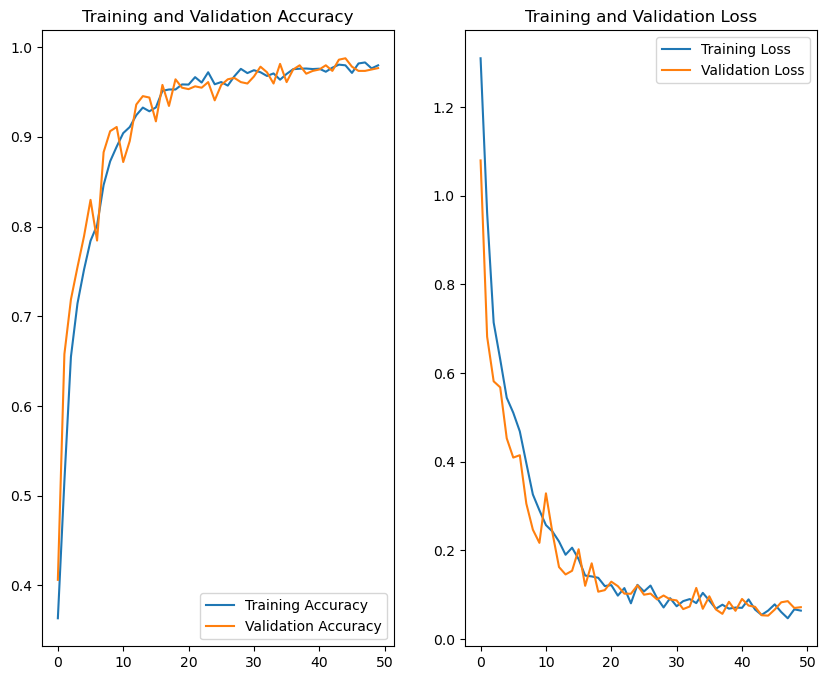

In [39]:
import numpy as np
# Assuming EPOCHS is set to the correct number of epochs
epochs_range = np.linspace(0, EPOCHS, len(acc), endpoint=False)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


first image to predict
actual label: Late_blight
1/1 [==============================] - 0s 366ms/step
predicted label: Late_blight


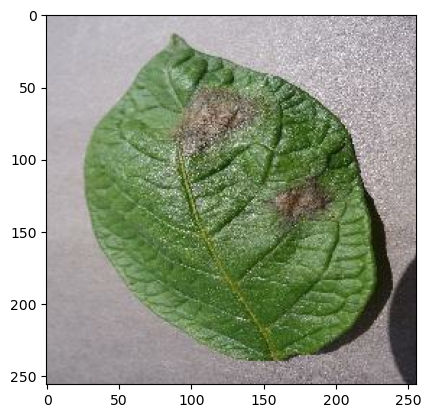

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
# inference function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


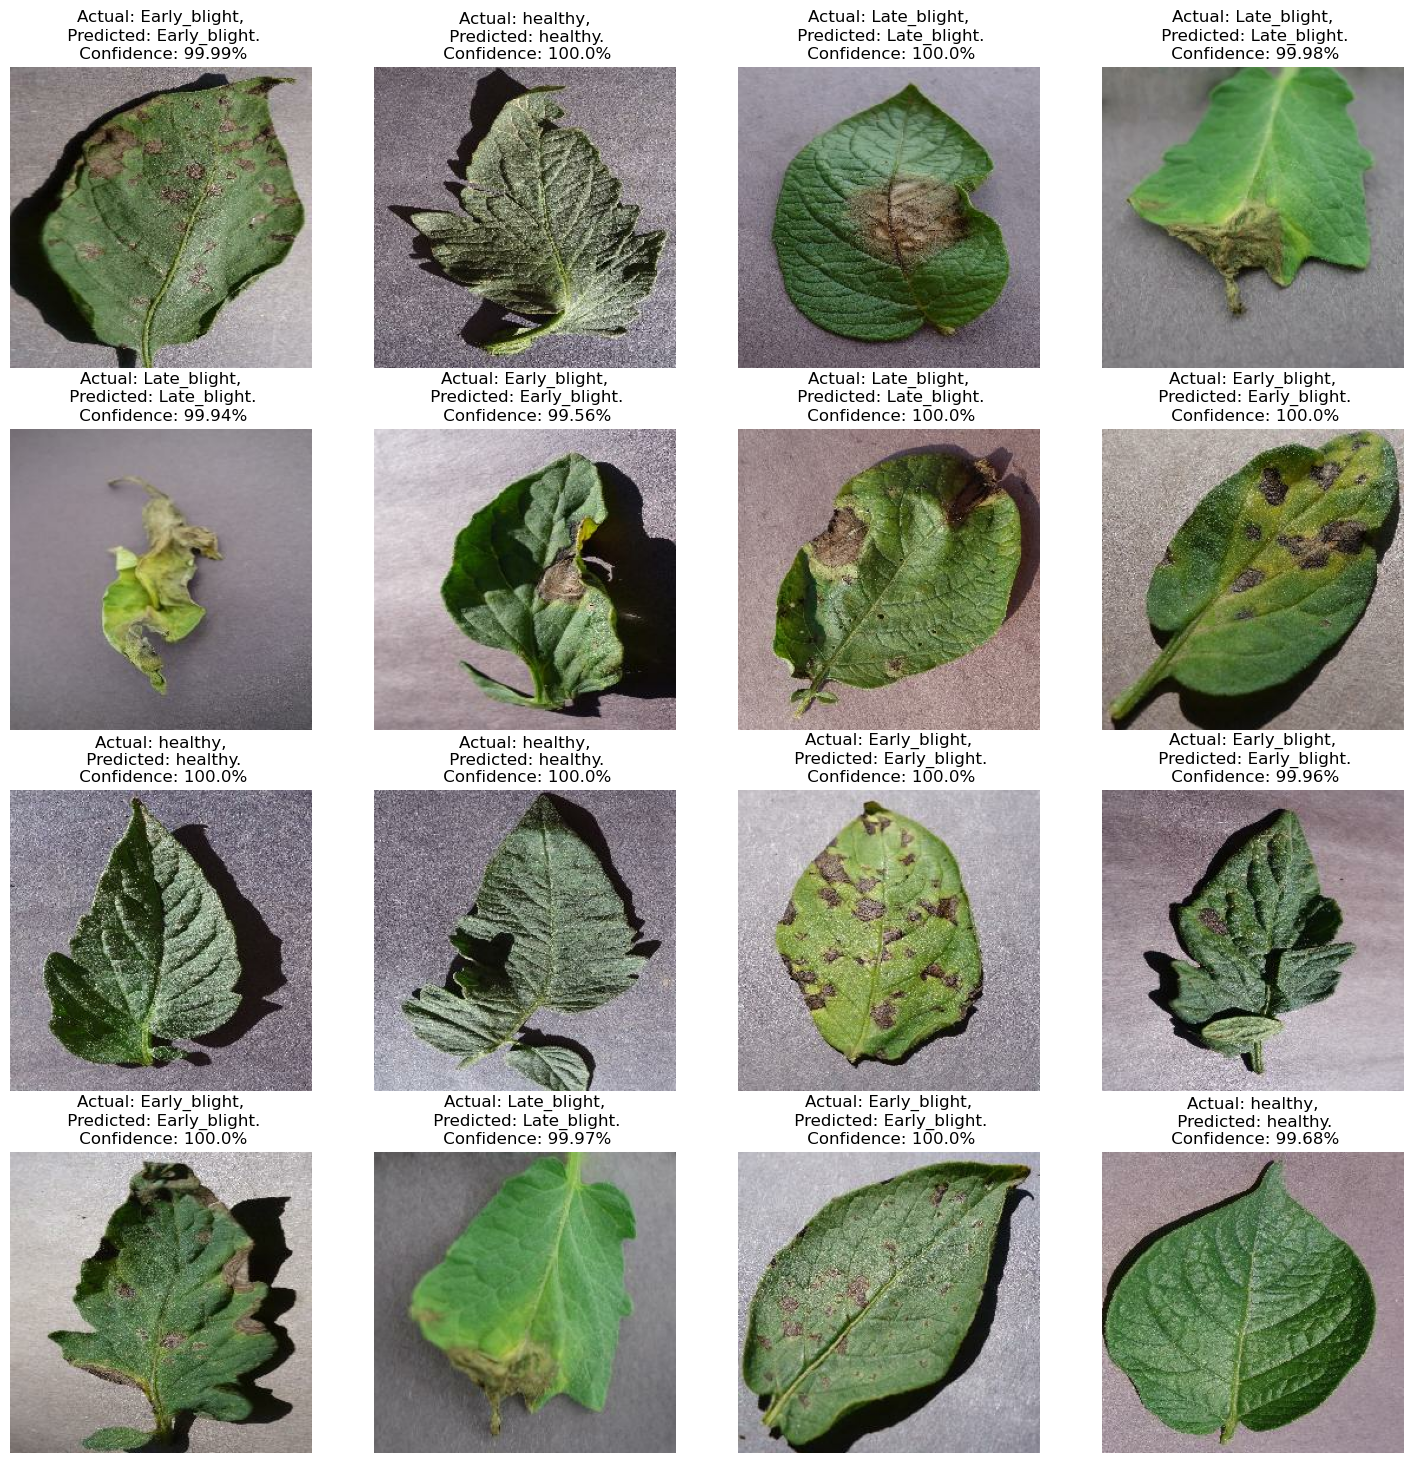

In [42]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [43]:
model.save("saved_model.h5")

/Users/pradhyumnyadav/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
import os

model_dir = "models"

# Check if the directory exists, and create it if not
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Now, you can proceed with your existing code
model_version = max([int(i) for i in os.listdir(model_dir)] + [0]) + 1
model.save(f"{model_dir}/{model_version}")


INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets
